In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import scipy as sp
import os
%load_ext autoreload
%autoreload 2

# data path, constants, etc.
import sys
datapath = '/Users/nhamilto/Documents/ATom/coderepo/ATom/'
sys.path.append(datapath)

# plot things
import matplotlib.pyplot as plt
plt.style.use('seaborn-deep')

# Acoustic tomography functions
import atom_functions as atom
import TDSI as TDSI

In [4]:
datapath = '../../data/20180928_processed_data/'
ttfiles = [datapath+file for file in os.listdir(datapath) if 'filtered_tt' in file]

In [7]:
tmp = TDSI.meanField(ttfiles[0])

new mean field


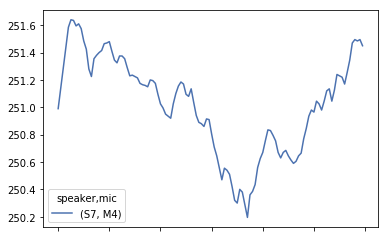

In [43]:
pathID = np.random.randint(64)
tt_path = tmp.travel_times.xs(pathID, level=2).T
tt_path.plot()

In [45]:
tmp.path_lengths.round(2)#.flatten()

array([[ 0.71, 31.39, 45.15, 76.05, 80.51, 81.53, 68.57, 42.24],
       [32.52,  0.7 , 24.03, 65.94, 79.54, 94.94, 90.68, 73.08],
       [46.28, 25.4 ,  0.71, 41.93, 58.48, 81.61, 84.86, 79.61],
       [76.65, 66.97, 43.13,  0.72, 23.12, 60.52, 77.99, 93.93],
       [80.77, 80.28, 59.47, 24.48,  0.69, 38.93, 61.34, 86.81],
       [81.19, 95.12, 82.11, 61.6 , 40.17,  0.71, 28.3 , 67.15],
       [67.82, 90.41, 84.9 , 78.7 , 62.31, 29.61,  0.69, 41.81],
       [40.97, 72.17, 78.94, 93.93, 87.17, 68.04, 42.97,  0.71]])

In [50]:
path_velocity = pd.DataFrame()
for col in tmp.travel_times.columns:
    path_velocity[col] =tmp.path_lengths.flatten()/(tmp.travel_times[col]/1000)

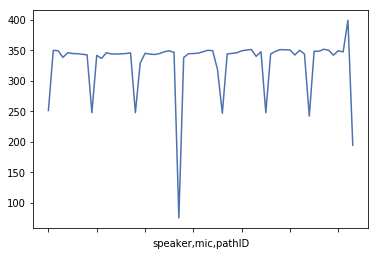

In [56]:
path_velocity.T.mean().plot()

In [177]:
tmp.travel_times['frame 0'].values.reshape(8,8).round(2)

array([[  3.63,  89.6 , 128.99, 224.54, 232.62, 236.92, 199.04, 123.52],
       [ 95.2 ,   2.84,  69.71, 196.06, 231.14, 276.42, 267.76, 213.07],
       [135.26,  73.6 ,   2.88, 128.04, 169.95, 238.54, 248.1 , 232.72],
       [220.82, 192.1 , 124.6 ,   9.49,  67.88, 176.54, 227.96, 272.96],
       [232.61, 229.41, 168.93,  82.5 ,   2.8 , 108.28, 178.5 , 250.99],
       [232.46, 270.63, 233.34, 180.76, 115.38,   2.86,  82.38, 192.86],
       [193.68, 257.26, 241.57, 229.2 , 178.27,  85.92,   2.82, 119.81],
       [117.22, 204.65, 224.97, 274.08, 248.98, 195.71, 107.66,   3.66]])

In [57]:
path_velocity.shape

(64, 120)

In [78]:
pathx = np.abs(np.repeat(tmp.mic_xy_m[:,0][:,np.newaxis],8,axis=1) - np.repeat(tmp.speaker_xy_m[:,0][:,np.newaxis],8,axis=1).T)
pathy = np.abs(np.repeat(tmp.mic_xy_m[:,1][:,np.newaxis],8,axis=1) - np.repeat(tmp.speaker_xy_m[:,1][:,np.newaxis],8,axis=1).T)

In [138]:
G = np.ones((56,3))

G[:,1] = pathx[~np.eye(pathx.shape[0],dtype=bool)].reshape(pathx.shape[0],-1).flatten()
G[:,2] = pathy[~np.eye(pathy.shape[0],dtype=bool)].reshape(pathy.shape[0],-1).flatten()

Ginv = np.linalg.pinv(G)

In [140]:
# pick a frame to look at
frameID=0
pv = path_velocity['frame 0']
pv[::9] = np.NaN
# D = 1/C
D = 1/pv.dropna()
# aver = average values of [1/c0, vx/c0**2, vy/c0**2]
aver = np.matmul(Ginv,D)
# Di is the least-squares estiamte of D
Di = np.matmul(G,aver)
# Residual and rmse
residual = Di-D
rmse = np.linalg.norm(residual)/(tmp.npaths-3)


In [141]:
# estimated speed of sound during frame
c0est = 1/aver[0]

# error of each term in Aver
std_aver = np.sqrt(rmse*np.diag(np.matmul(Ginv,Ginv.T)))

err_c0 = std_aver[0]*c0est**2
err_c2 = 2*c0est*err_c0

In [147]:
std_aver[0]*c0est

0.4425680576019211

In [148]:
# gamma = Cp/Ct ratio of specific heats of air
gamma = 1.4
# Gas constant for air
Ra = 287.058
gR = gamma*Ra

In [153]:
# estimate of mean temperature from data
T0est = c0est**2/gR
# error estiamte of T
err_T = err_c2/gR

In [160]:
# mean field estimates of vx and vy
vx0est = aver[1]*c0est**2
vy0est = aver[2]*c0est**2

# error of mean field estimates of vx and vy
err_vx = c0est**2*std_aver[1]
err_vy = c0est**2*std_aver[2]

In [169]:
pathlengths = np.sqrt(pathx**2 + pathy**2)
pathlengths = pathlengths[~np.eye(pathlengths.shape[0],dtype=bool)].reshape(pathlengths.shape[0],-1).flatten()
tt_meanfield = pathlengths*(residual + Di)

In [189]:
tt_flucfield = tmp.travel_times['frame {}'.format(frameID)][~np.eye(8).flatten()]/1000 - tt_meanfield

TypeError: ufunc 'invert' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

Text(0.5,0,"Int64Index([ 1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 12, 13, 14, 15, 16, 17, 19,\n            20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35, 37, 38,\n            39, 40, 41, 42, 43, 44, 46, 47, 48, 49, 50, 51, 52, 53, 55, 56, 57,\n            58, 59, 60, 61, 62],\n           dtype='int64', name='pathID')")

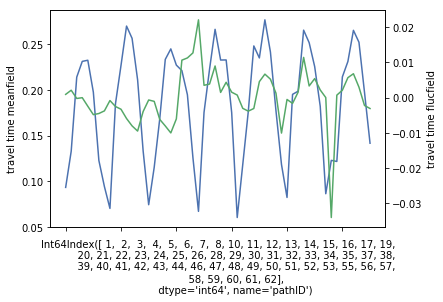

In [219]:
fig, ax = plt.subplots()
tt_meanfield.plot(ax=ax)
ax.set_ylabel('travel time meanfield')
axtwin = ax.twinx()
mask = np.abs(1-np.eye(8).flatten()).astype(bool)
test = tt_flucfield.where(mask).dropna()
test.plot(ax=axtwin, color='C1')
axtwin.set_ylabel('travel time flucfield')
ax.set_xlabel(tt_meanfield.index.get_level_values(2))

In [218]:
tt_meanfield.index.get_level_values(2)

Int64Index([ 1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 12, 13, 14, 15, 16, 17, 19,
            20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35, 37, 38,
            39, 40, 41, 42, 43, 44, 46, 47, 48, 49, 50, 51, 52, 53, 55, 56, 57,
            58, 59, 60, 61, 62],
           dtype='int64', name='pathID')

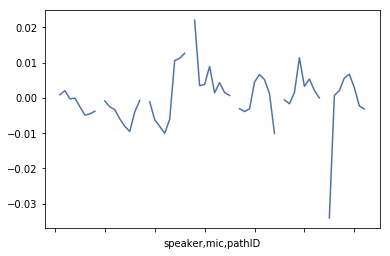

In [181]:
fig, ax = plt.subplots()
tt_flucfield.plot(ax=ax)

In [202]:
mask = np.abs(1-np.eye(8).flatten()).astype(bool)
test = tmp.travel_times['frame {}'.format(frameID)]
test.where(mask).dropna()

speaker  mic  pathID
S1       M0   1          89.600
S2       M0   2         128.985
S3       M0   3         224.535
S4       M0   4         232.615
S5       M0   5         236.920
S6       M0   6         199.040
S7       M0   7         123.520
S0       M1   8          95.200
S2       M1   10         69.710
S3       M1   11        196.055
S4       M1   12        231.140
S5       M1   13        276.415
S6       M1   14        267.755
S7       M1   15        213.070
S0       M2   16        135.255
S1       M2   17         73.595
S3       M2   19        128.045
S4       M2   20        169.955
S5       M2   21        238.540
S6       M2   22        248.100
S7       M2   23        232.725
S0       M3   24        220.825
S1       M3   25        192.095
S2       M3   26        124.605
S4       M3   28         67.875
S5       M3   29        176.540
S6       M3   30        227.965
S7       M3   31        272.960
S0       M4   32        232.610
S1       M4   33        229.410
S2       M4   34   

In [198]:
bool(np.abs(1-np.eye(8).flatten()))

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [200]:
np.abs(1-np.eye(8).flatten()).astype(bool)

array([False,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
       False])